# Examining the Predictive Fairness of Recidivism Models

The topic of fairness in machine learning has garnered much attention in recent years, particularly in the context of criminal justice. One such case is the use of the COMPAS system by Northpointe, which uses machine learning algorithms to predict recidivism in defendants. The results of the COMPAS system have been the subject of numerous claims, both in support and against its fairness.

In this notebook, we aim to examine the claims surrounding the COMPAS system's fairness in predicting recidivism. We use recidivism data that was provided by the Broward County, Florida to ProPublica, the first initiative to analyse the fairness. We aim to reproduce the claims made by ProPublica, Northpointe, and the Washington Post. In the second part of the paper, we address some important questions about fairness in machine learning models. Finally, we aim to answer the question of whether recidivism can be predicted based on simple factors such as age, gender, race, and prior history of recidivism. We also compare the performance of a more complex tree-based statistical model with a simpler logistic regression model.

## Data Preparation

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split,cross_validate, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
import os
warnings.filterwarnings('ignore')

In [49]:
# set global random seed
rand = 3
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

We use the `Compas-scores-two-years` dataset published by ProPublica and apply the same data filter used by them to create a new dataframe compas_df. The dataset contains information on defendants charged with a crime and assessed using the COMPAS risk assessment tool. The data includes demographic information, criminal history, and the results of the COMPAS assessment, including a predicted risk score and likelihood of recidivism over a two-year period. The filter selects only the rows from the data where the number of days between the arrest and the screening is within the range of -30 to 30, the value in the is_recid column is not -1, the value in the c_charge_degree column is not "O", and the value in the score_text column is not "N/A".

In [50]:
dataURL = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
raw_data = pd.read_csv(dataURL)
raw_data.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [51]:
compas_df = raw_data.loc[
    (raw_data['days_b_screening_arrest'] <= 30) &
    (raw_data['days_b_screening_arrest'] >= -30) &
    (raw_data['is_recid'] != -1) &
    (raw_data['c_charge_degree'] != "O") &
    (raw_data['score_text'] != "N/A")
]
compas_df.shape

(6172, 53)

In [52]:
# load COX data
parsed_dataURL = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-parsed.csv'
parsed_data = pd.read_csv(parsed_dataURL)
print(parsed_data.shape)
parsed_data.columns


(13419, 52)


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event'],
      dtype='object')

## Exploratory Analysis

In this exploratory data analysis, we will examine the structure and characteristics of the dataset, including its size, distribution of variables, and any missing or abnormal values. We will also create visualizations to help identify patterns and relationships between variables. The insights gained from this analysis will be used to guide the development of hypotheses and the choice of statistical models for our subsequent analysis.

### Race Variables

Initially, we assess the distribution of Race Variables.

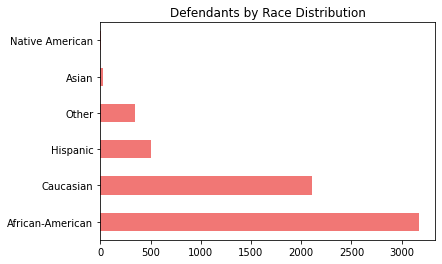

In [53]:
compas_df['race'].value_counts().plot(
    title = "Defendants by Race Distribution",
    kind= "barh", 
    color = "#f17775")

It can be clearly seen from the graph that the sample is unbalanced with regards to the race variable, where the sample data of COMPAS have extremely small representation of Asian and Native American. According to the US Census data, Asians make up about 5.23% of the nation’s overall population in 2014; in the ProPublica, however, they accounts for only 0.5% of the data. Caucasians and African-Americans represent the biggest race groups in the dataset.

In [54]:
value_counts = compas_df['race'].value_counts()
percentage = np.round(value_counts / len(compas_df) * 100,3)

table = pd.concat([value_counts, percentage], axis=1)
table.columns = ['Value Counts', 'Percentage']
print("Race Distribution of Defendants")
print(table)

Race Distribution of Defendants
                  Value Counts  Percentage
African-American          3175      51.442
Caucasian                 2103      34.073
Hispanic                   509       8.247
Other                      343       5.557
Asian                       31       0.502
Native American             11       0.178


### Sex Variables

Looking at the sex variable, it shows that there is a significant imbalance in the distribution of males and females in the sample population, with males accounting for approximately 81% of the sample and females accounting for approximately 19%. 

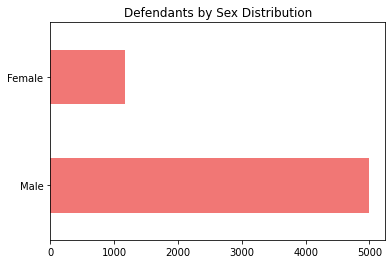

In [55]:
compas_df['sex'].value_counts().plot(
    title = "Defendants by Sex Distribution",
    kind= "barh", 
    color = "#f17775")

In [56]:
value_counts = compas_df['sex'].value_counts()
percentage = np.round(value_counts / len(compas_df) * 100,3)

table = pd.concat([value_counts, percentage], axis=1)
table.columns = ['Value Counts', 'Percentage']
print("Sex Distribution of Defendants")
print(table)

Sex Distribution of Defendants
        Value Counts  Percentage
Male            4997      80.962
Female          1175      19.038


### Age Variable

The histogram shows that most of the defendants in the COMPAS data are between the ages of 25 and 35, with a concentration of ages towards the younger end of this range. This type of distribution can indicate that the population of defendants in the COMPAS data is relatively young, with fewer older defendants. 

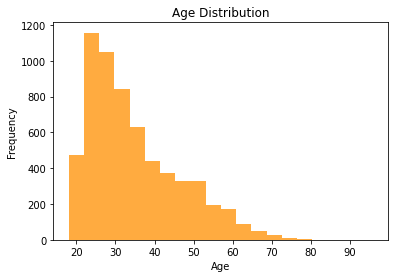

In [57]:
plt.hist(compas_df['age'], bins=20, color='#ffab40')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

Given that African American and Caucasian groups are the predominant populations in our dataset, and ProPublica, Northpoint and the Washington Post also do concentrate on these two groups, we will analyze age distributions within these two populations to gain a deeper understanding of their demographic structures. 

The distribution below shows that African-Americans defendants tend to be younger than Caucasians defendants.

In [58]:
# to customize the histogram color
import matplotlib.cm as cm
import matplotlib.colors as colors

def hist_color(color_code_start, color_code_end, n):
    cmap = cm.colors.LinearSegmentedColormap.from_list("MyColorMap", [color_code_start, color_code_end], N = n)
    colors_array = cmap(colors.Normalize()(range(n)))
    color_codes = [colors.to_hex(c) for c in colors_array]
    return color_codes

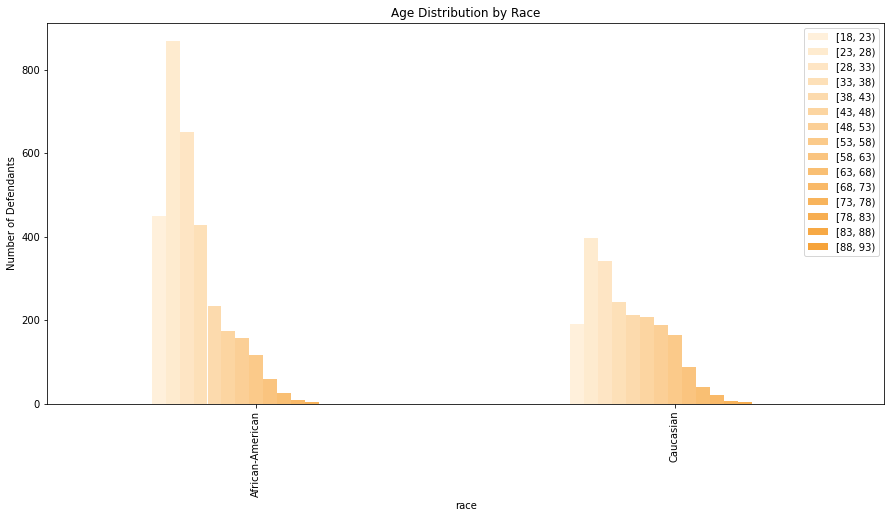

In [59]:
min_age = int(compas_df['age'].min())
max_age = int(compas_df['age'].max())
age_bins = np.arange(min_age, max_age+1, 5)

compas_df[compas_df['race'].isin(["African-American","Caucasian"])].groupby('race')['age'].apply(lambda x: pd.cut(x, bins = age_bins, right = False).value_counts(normalize = False)).unstack().plot(
    kind='bar', 
    color = hist_color('#fff0db', '#f38800', 20),
    figsize=(15, 7),
    title='Age Distribution by Race', 
    ylabel='Number of Defendants'
)

### Priors_Count Variable

From the distribution of the priors count variable, we see that the dataset tends to have few priors.

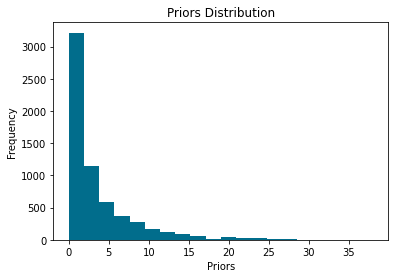

In [60]:
plt.hist(compas_df['priors_count'], bins=20, color='#016d8c')
plt.title("Priors Distribution")
plt.xlabel("Priors")
plt.ylabel("Frequency")
plt.show()

As done before for the age variable, we here also look at the age feature for African-Americans and Caucasians in a direct comparison. It shows that African-Americans are 

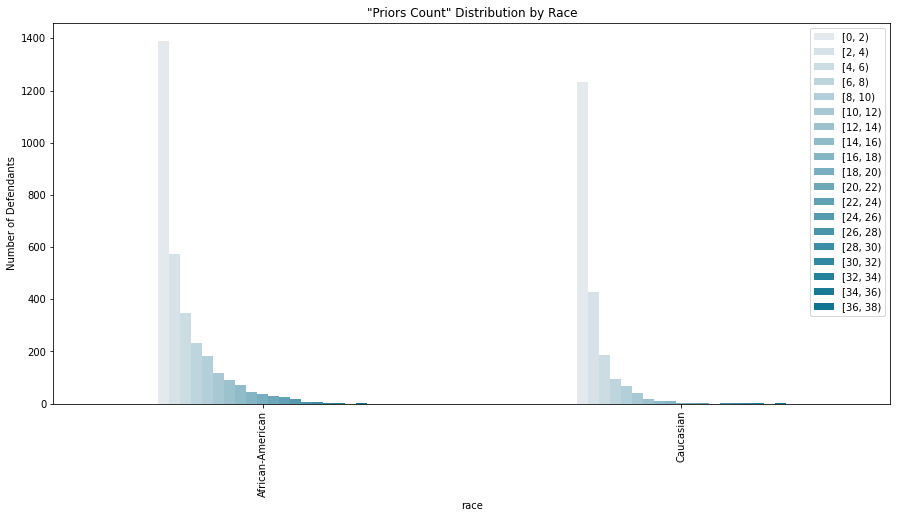

In [61]:
min_priors = int(compas_df['priors_count'].min())
max_priors = int(compas_df['priors_count'].max())
count_bins = np.arange(min_priors, max_priors + 1, 2)

compas_df[compas_df['race'].isin(["African-American","Caucasian"])].groupby('race')['priors_count'].apply(lambda x: pd.cut(x, bins = count_bins, right = False).value_counts(normalize = False)).unstack().plot(
    kind='bar', 
    color = hist_color('#e3e9ed', '#016d8c',20),
    figsize=(15, 7),
    title='"Priors Count" Distribution by Race', 
    ylabel='Number of Defendants'
)


### Correlation between Features

This heatmap shows a positive correlations for the decile score with two year recidivism. Meaning that the assigned decile score by COMPAS does indeed represent a tendency of defendants with high scores to be recidivating. 

This heatmap also shows a positive correlations for the decile score with  priors and  a negativ correlation with age. This means that overall the more crimes the defendant has commited before, the higher his / her score and that overall younger defendant have  higher scores.
This is not surprising as both are also correlated with two year recidivism.

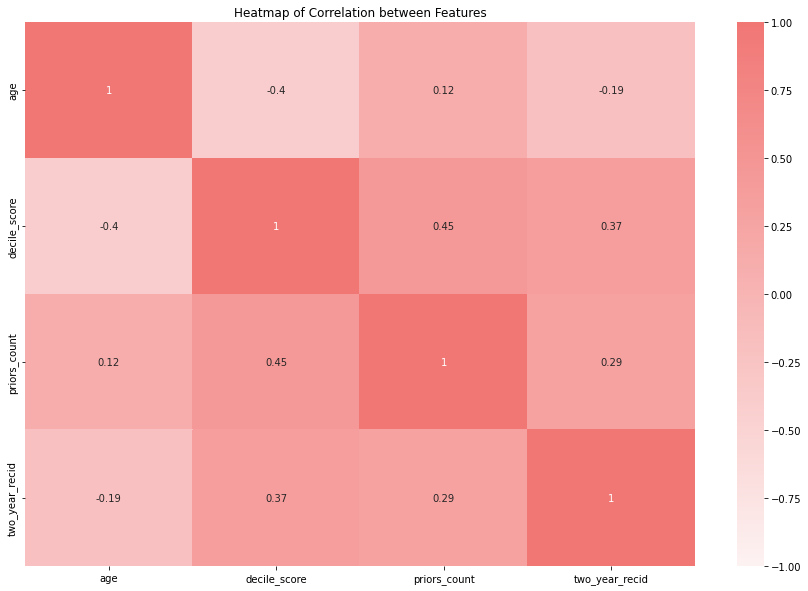

In [62]:

import matplotlib.colors as mcolors

colors = ['#fdf2f2', '#f17775']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

plt.figure(figsize=(15, 10))
sns.heatmap(compas_df[['age', 'race', 'sex', 'decile_score', 'priors_count', 'two_year_recid']].corr(), annot=True, cmap=cmap, vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between Features')
plt.show()

### Decile Scores

Next, we examine the distribution of COMPAS decile scores across different racial groups in relation to recidivism.

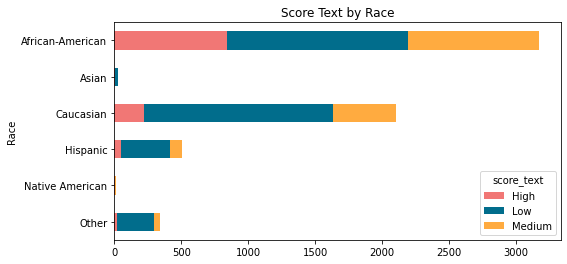

In [63]:
score_text_by_race = compas_df.groupby(['race','score_text'], sort = True)['id'].size()
score_text_by_race.unstack().sort_values(by="race", ascending=False).plot(
    kind = "barh", 
    title = "Score Text by Race",
    ylabel = "Score Text",
    xlabel = "Race",
    color = ["#f17775", "#016d8c", "#ffab40"],
    figsize = (8,4),
    stacked = True
)

African American defendants have the highest number of defendants classified with high scores. However, it is important to consider that African Americans make up the largest racial group in this dataset, representing 51.442% of the total. 

To better understand the distribution of decile scores among different racial groups, we plotted the histogram as below. The chart reveals a noticeable pattern. As the decile score increases, the proportion of defendants from both the Caucasian, Hispanics, Asians and 'Other' racial groups decreases. However, this trend is not observed in the African American and the Native American groups, where the proportion of defendants remains relatively stable across different decile scores.

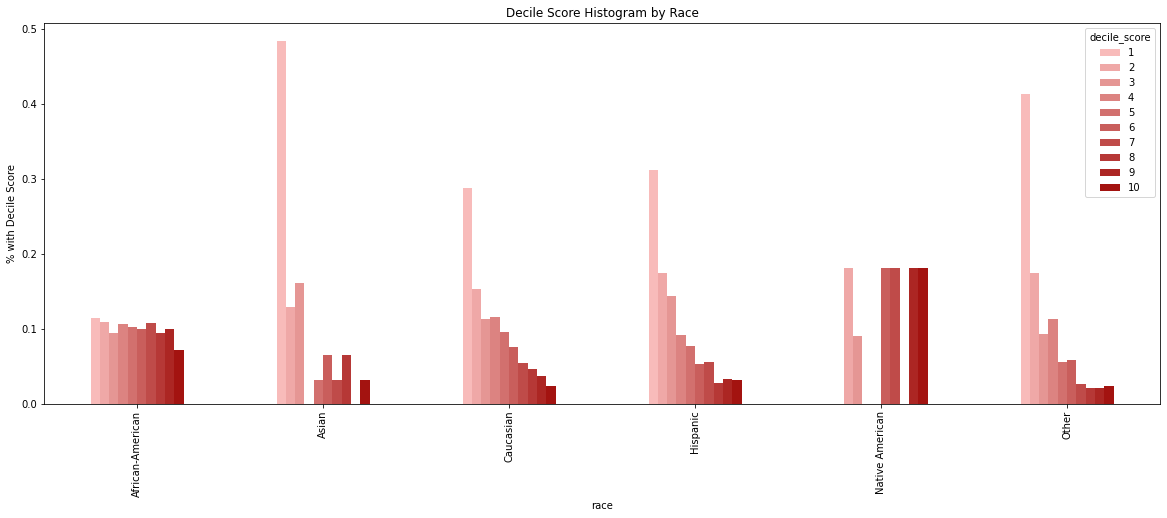

In [65]:
import matplotlib.cm as cm
import matplotlib.colors as colors

cmap = cm.colors.LinearSegmentedColormap.from_list("MyColorMap", ['#F8BBBA', '#A31310'], N=10)
colors_array = cmap(colors.Normalize()(range(10)))
color_codes = [colors.to_hex(c) for c in colors_array]

compas_df.groupby('race')['decile_score'].value_counts(normalize=True).unstack().plot(
    kind='bar', 
    color = color_codes,
    figsize=(20, 7),
    title='Decile Score Histogram by Race', 
    ylabel='% with Decile Score'
)

## Replicating the Analysis

In [66]:
df = compas_df.copy()

### ProPublica analysis

ProPublica in their article claims that the COMPAS algorithm is biased agains black people. They based their argument on the following:
- The distributions of decile scores is different in each of the groups, where white people are assigned more low scores whereas for African-Americans the distribution is more balanced.
- Black people are more likely to be assigned a high score.
- White people were more often wrongly assigned low scores than blacks.

*Next*, we will reproduce some of the claims.

**Compas Score Distribution**

In [67]:
# Create a dataframe with only the african-americans and caucasians
df_binary = df.loc[df['race'].isin(["African-American","Caucasian"])]

In [68]:
# Calculate the total and proportions of decile scores per race
decile_score_by_race_prop= df_binary.groupby(['race', 'decile_score']).agg({'decile_score': 'count'})
decile_score_by_race_prop['prop'] = decile_score_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))

In [69]:
# Calculate the total and proportions of recidivates per race
is_recid_by_race_prop= df_binary.groupby(['race', 'is_recid']).agg({'decile_score': 'count'})
is_recid_by_race_prop['prop'] = is_recid_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))

Text(0, 0.5, 'Count')

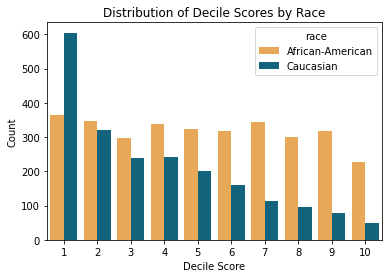

In [70]:
sns.countplot(
    data = df_binary,
    x = 'decile_score',
    hue = 'race',
    palette = ["#ffab40","#016d8c"]
)
plt.title('Distribution of Decile Scores by Race')
plt.xlabel('Decile Score')
plt.ylabel('Count')

In this plot we can see that Caucasians's distribution of scores is skewed towards lower scores, whereas African Americans have a similar numbers for each of the scores.

**Most predictive factors in logistic model (with controlling for other factors) for score**

In [71]:
# As in the ProPublica article the score text "medium" and "high" are labeled "high", the score text "low" stays the same in order to have binary score texts
df['score_text_binary'] = df['score_text'].replace(['Medium'], 'High')

In [72]:
# In order to be able to use this labeling in the regression, the labels need to be numerical
df['score_text_binary']= df['score_text_binary'].replace(['High'], 1)
df['score_text_binary']= df['score_text_binary'].replace(['Low'], 0)

ProPublica claims that Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior (when adjusted for other variables).

For that, we reproduced the logistic regression they made, and later we adjust it.

In [73]:
# Logistic Regression: Where the intercept doesn't take the right value automatically, we set it via the reference. 
# The Intercept shall be: white, male, aged between 25-45
import statsmodels.formula.api as smf

est = smf.logit('score_text_binary ~ C(age_cat) + C(race, Treatment(reference="Caucasian")) + C(sex,Treatment(reference="Male")) + priors_count + C(c_charge_degree) + two_year_recid', df).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      score_text_binary   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Wed, 15 Feb 2023   Pseudo R-squ.:                  0.2729
Time:                        08:41:19   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Interc

In [74]:
# Controlling for other variables by taking the Intercept to have a control and a treatment group
ControlgGroup= np.exp(-1.5255)/(1+ np.exp(-1.5255))
FinalClaim= np.exp(0.4772)/(1- ControlgGroup + (ControlgGroup * np.exp(0.4772)))
FinalClaim
# Interpretation: Black people are 45% more likely to be assesed as high risk

1.452825407001621

The FinalClaim 1.45 indicates that Black people are 45% more likely to be assesed as high risk

### Northpointe's Rebuttal Analysis

**Different base rates for recidivism**

Northpointe, in their rebuttal to the ProPublica article, explain that:
- Propublica failed to include information about the data they used. White people got lower values because they have lower imputs of the risk scales, such as less drug problems, less criminal history, older age than for the black people sample. In addition, white people have lower base rates for recidivism.
- COMPAS has equal discriminative ability (equally accurate) for blacks and whites because the AUC for white and black defendant are not significally different. 
- ProPublica confuses model errors with the target population error. To test racial bias, Northpointes argues that the target population errors should be analyzed, and not the model errors as ProPublica did. They explain that the false positive rate (meaning assign someone as high risk when they are not) will increase if the base rate increases (high recidivism rates for black people). 


**Different base rates for recidivism**

Text(0, 0.5, 'Count')

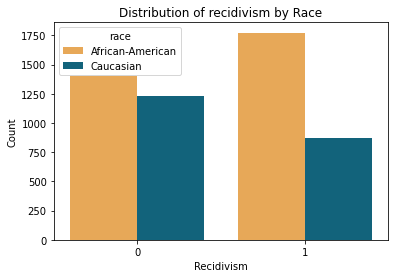

In [75]:
sns.countplot(
    data = df_binary,
    x = 'is_recid',
    hue = 'race',
    palette = ["#ffab40","#016d8c"]
)
plt.title('Distribution of recidivism by Race')
plt.xlabel('Recidivism')
plt.ylabel('Count')

On this plot we can see the different base rates for recidivisim in African-American and Caucasian groups. Black people recidivate at a higher rate than white people. This, as Northpointe explains, will affect the FPR.

**Similar AUC and error rates**

In addition, since Northpointe based their rebuttal on showing that the AUC and error rates for both groups are not significally different. 

We wanted to reproduce the ROC for the Sample A as Northpointe did. Sample A, as mentioned in their article, "consists of pretrial defendants with complete case records who have at least two years of follow-up time. The PP authors use Sample A to fit reverse logistic regressions predicting the“Not Low”Risk Level."

In [76]:
# Convert categorical features to numeric levels
for feature in df.columns:
    if df[feature].dtype=="object":
      le = LabelEncoder()
      le.fit(df.columns)
      df[feature] = le.fit_transform(df[feature].astype(str)) #le.fit_transform(df_train[feature].astype(str))

In [77]:
# Dataframe of target: binary score text
y = df.score_text_binary

We take the same features as ProPublica did for their logistic regression. This is what Northpointe did as well (Sample A)

In [78]:
X = df[['age_cat','race', 'sex', 'priors_count','c_charge_degree', 'two_year_recid']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.11, random_state = 94)

Although we used the same sample A for our ROC, the AUC is different from Northpointe (AUC=0.71).

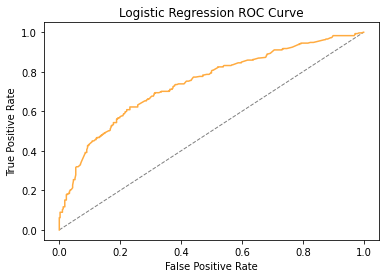

The total AUC is  0.7419049137350764


In [79]:
# Fit logisti regression
clf2 = LogisticRegression(solver='newton-cg')
clf2.fit(X_train,y_train)

# Predict y probability 
y_pred = clf2.predict_proba(X_test) 
y_pred_prob = y_pred[:,1]

# ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed', linewidth = 1)
plt.plot(fpr, tpr, label='Logistic Regression', color= '#ffab40')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

#AUC
print('The total AUC is ', metrics.roc_auc_score(y_test, y_pred_prob))

Although we used the same sample A for our ROC, the AUC is different from Northpointe (AUC=0.71).

### The Washington Post 1 Analysis

The Washington Post 1 goes beyond the claims from Northpointe and ProPublica, and gives a more comprehensive explanation.

Basically, they claim that an algorithm can't be fair on both ways:
- Northpointe's definition of fairness: in each risk score, both groups have the same proportion of recidivism.
- ProPublica definition of fairnes: among defendants who did not reoffend, the proportion of blacks and whites that were classified as low risk should have been the same. As we shown, black defendants are more likely to be classified as High risk although they later wouldn't reoffend.


In [80]:
def calibration_curve(df):
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

In [81]:
# Create Datafram with only african-americans
df_black = raw_data.loc[raw_data['race'].isin(["African-American"])]
df_black.shape

(3696, 53)

Washington Post shows the Northpointe's definition of fairnes with the following graphic, which shows the recidivism rate by risk score and race. White and black defendants with the same risk score are roughly equally likely to reoffend.

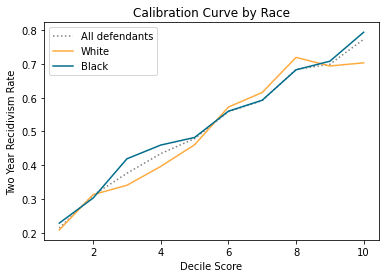

In [82]:
# for all data in the dataset
cal_all = calibration_curve(raw_data)
cal_all.plot(linestyle = 'dotted', 
              color = 'gray',
              label= "All defendants")

# White Defendants
cal_white = calibration_curve(raw_data[raw_data['race'] == "Caucasian"])
cal_white.plot(
    color = "#ffab40",
    label = "White")

# Black Defendants
cal_black = calibration_curve(raw_data[raw_data['race'] == "African-American"])
cal_black.plot(
    color = "#016d8c",
    label='Black')

# Add title and label
plt.title("Calibration Curve by Race")
plt.xlabel("Decile Score")
plt.ylabel("Two Year Recidivism Rate")
plt.legend()

In [83]:
# Create Datafram with only african-americans
df_black = raw_data.loc[raw_data['race'].isin(["African-American"])]

# Create dataframe with only caucasians
df_white = raw_data.loc[raw_data['race'].isin(["Caucasian"])]

In this section, we will perform the following steps to analyze the data per race:

* Relabel the score text as before, but instead of using numerical values, we will use descriptive labels.

* Divide the dataframe into two groups: those who recidivated and those who did not.

In [84]:
# Per race:
# Relabel the score text as before but not with numerical
# Devide dataframe in recidivated and non-recidivated
df_white['score_text'] = raw_data['score_text'].replace(['Medium'], 'Medium/High').replace(['High'], 'Medium/High')
df_white_recid = df_white.loc[df_white['is_recid'].isin([1])]
df_white_nonrecid = df_white.loc[df_white['is_recid'].isin([0])]

df_black['score_text'] = raw_data['score_text'].replace(['Medium'], 'Medium/High').replace(['High'], 'Medium/High')
df_black_recid = df_black.loc[df_black['is_recid'].isin([1])]
df_black_nonrecid = df_black.loc[df_black['is_recid'].isin([0])]

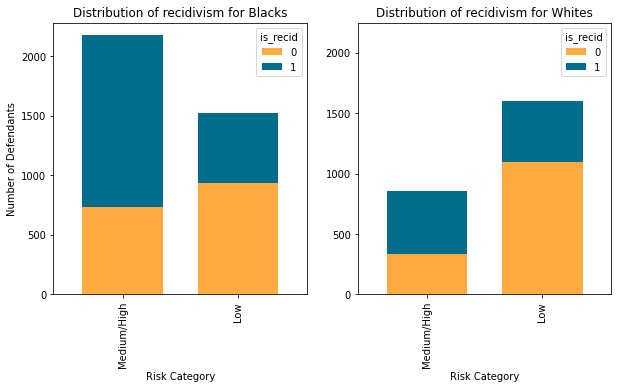

In [85]:
# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot first dataframe
df_plot = df_black.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
df_plot.plot(
    kind='bar', 
    stacked=True,
    width=0.7,
    title='Distribution of recidivism for Blacks',
    color=["#ffab40","#016d8c"],
    ax=ax1)
ax1.set_xlabel("Risk Category")
ax1.set_ylabel("Number of Defendants")
ax1.invert_xaxis()
plt.ylim([0, 2250])
plt.yticks([0, 500, 1000, 1500, 2000])

# Plot second dataframe
df_plot = df_white.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
df_plot.plot(
    kind='bar', 
    stacked=True,
    width=0.7,
    title='Distribution of recidivism for Whites',
    color=["#ffab40","#016d8c"],
    ax=ax2)
ax2.set_xlabel("Risk Category")
ax2.set_ylabel("")
ax2.invert_xaxis()
plt.ylim([0, 2250])
plt.yticks([0, 500, 1000, 1500, 2000])

# Show plot
plt.show()

Finally, on their article they show the previous chart to visualize two things:
- The proportion of defendants who reoffend is the same for black and white people.
- The recidivism base rate for black defendants is higher than for white defendants.

With this, they explain that innevitably a greater amount of black defendant will be classified as high risk, and with that more black defendant will also be missclassified as high risk.

In relation to what Northpointe said, if the prevalence (recidivism base rate) for both groups is different, then is not possible for both errors (model and population) to be fair.

Northpointe has "fair", meaning similar, population errors, and therefore the FPR (model error) will be higher for black people.

## Recidivism Classification

### Processing Data

Our hypothesis focuses on the predictability of recidivism based on simple factors, therefore, we only use a subset of the features available in the dataset. The selected features include 'sex', 'age', 'race', 'priors_count', and 'c_charge_degree', which will be used to predict the two-year recidivism. These features were chosen based on their simplicity and potential impact on recidivism, and represent a mix of demographic and criminal history information."

In [86]:
df = compas_df.copy()

In [87]:
df = df[['sex', 'age', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']]
df.shape

(6172, 6)

#### Data bias 
To solve the data imbalance this issue in Race group, we merge these two groups into a single "Other" group, making the sample data more balanced and allowing us to make more accurate predictions."

In [88]:
df.loc[df['race'].isin(['Native American', 'Asian']), 'race'] = "Other"
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                385
Name: race, dtype: int64

#### Data Imbalance

In this step, we are checking the balance of the target variable, which is the rate of recidivism. According to the data, the rate of defendants who do not recidivate is 45.51% and the rate of recidivism is 54.49%. This means that the data is imbalanced, with a higher rate of recidivism than defendants who do not recidivate. Despite the imbalance, the difference in the rate is small, so we have decided to leave it as it is, without making any adjustments.

In [89]:
not_recid = (df['two_year_recid'].sum()/df['two_year_recid'].shape[0])*100

print("Not Recidivism Rate: %.3f%%" % not_recid)
print("Recidivism Rate: %.3f%%" % (100-not_recid))

Not Recidivism Rate: 45.512%
Recidivism Rate: 54.488%


#### Convert Categorical Data

The categorical data is converted into numerical data with OneHotCoder. The purpose of converting these variables into numerical form is to make it easier for machine learning algorithms to work with the data. In addition, to ensure consistency and accurate scaling, the numerical data is then standardized using StandardScaler. This helps to eliminate any biases or disparities that may be present in the data, leading to more accurate results from machine learning models.

In [90]:
categorical_features = ['race', 'sex', 'c_charge_degree']
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(drop='if_binary'))
])

numerical_features = ['age', 'priors_count']
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

# Pipeline for Data Preprocess
preprocessor = ColumnTransformer(transformers=[
        ('cate', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
])

### Model Implementation

#### Training and Testing Data

The dataset was divided into two parts: 70% for training and 30% for testing. In order to ensure that the proportion of positive and negative samples in both the training and testing datasets was the same as in the original dataset, the stratified sampling approach was used with the target variable 'two_year_recid' as the stratification criterion. This helps to avoid any bias in the model evaluation that could result from an imbalanced distribution of the target variable in the training and testing datasets.

In [91]:
# define features, target, and stratify for splitting
features = df[['sex','age','race','priors_count','c_charge_degree']]
target = df['two_year_recid']
stratify = df['two_year_recid']
race = df['race'] # for fairness check later

In [92]:
X_train, X_test, y_train, y_test, race_train, race_test = train_test_split(
        features, 
        target, 
        race,
        test_size = 0.3,
        random_state = rand
)

#### Model Selections

We use Logistic Regression as the baseline model due to its simplicity and ease of interpretability. It is widely used for binary classification problems and can provide a quick and efficient solution for our problem.

For the tree-based models, we use Decision Tree and Random Forest. Random Forest is an ensemble model that builds multiple decision trees and aggregates their predictions to reduce overfitting and improve accuracy. Decision Tree, on the other hand, builds a single tree from the training data, making it easier to interpret the model. These two models are popular for their performance, scalability, and ability to handle large datasets. 

Initially, the model is implemented on the training data without any tuning or adjustments to the model's parameters. This allows us to obtain a baseline performance of the model and serves as a starting point for further optimization.

In [93]:
classifiers = {
    'Logistic Regression': {'model': Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state = rand))])},
    'Decision Tree' : {'model': Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state = rand))])},
    'Random Forest' : {'model': Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state = rand))])}
}

#### Evaluation Metrics
The F1 score and AUC ROC are used as the evaluation metrics for the models due to the slight imbalance in the data class. These metrics provide a comprehensive evaluation of the model's performance in terms of precision, recall, and accuracy, allowing us to address the imbalance in the data class and accurately assess the model's ability to predict recidivism. In addition, cross validation using Stratified Kfolds with 5 splits is also employed to improve the robustness of the model evaluation results.

In [94]:
# create a df to store the cross-validation results of each model
cv_result = pd.DataFrame(columns= ['Model', 
                                   'AVG F1', 
                                   'AVG AUC', 
                                   'AVG Precision', 
                                   'AVG Recall', 
                                   'AVG Accuracy'])

In [95]:
for model_name in classifiers.keys():
    model = classifiers[model_name]['model']
    
    # define scoring metrics
    scoring = ['f1','roc_auc','precision','recall','accuracy']
        
    # generate cross validation for with defined random state
    skf = StratifiedKFold(n_splits = 5, random_state = rand, shuffle = True)
        
    # cross validation
    scores = cross_validate(
        model, 
        X_train, 
        y_train, 
        scoring = scoring, 
        cv = skf)
    cv_result = cv_result.append({'Model': model_name, 
                                  'AVG F1': scores['test_f1'].mean(), 
                                  'AVG AUC': scores['test_roc_auc'].mean(),
                                  'AVG Precision': scores['test_precision'].mean(), 
                                   'AVG Recall': scores['test_recall'].mean(), 
                                   'AVG Accuracy': scores['test_accuracy'].mean()
                                 }, ignore_index = True
                                )

In [96]:
# print the result, sort by the AVG F1
print("Cross Validation Result")
cv_result.sort_values(by='AVG F1', ascending=False)

Cross Validation Result


,Model,AVG F1,AVG AUC,AVG Precision,AVG Recall,AVG Accuracy
0,Logistic Regression,0.607257,0.721527,0.675775,0.551654,0.675694
2,Random Forest,0.565130,0.658175,0.575591,0.555216,0.611343
1,Decision Tree,0.525996,0.606750,0.566048,0.491603,0.597454


The Logistic Regression model has demonstrated the best performance in terms of F1 score and AUC ROC. As a next step, we will fine-tune the tree-based models to see if we can improve their performance and find a model that outperforms Logistic Regression.

#### Model Tuning

We utilized Random Search to find the best hyperparameters for each of the tree-based models. The hyperparameters are the parameters that cannot be learned from the training data and are used to control the learning process of the model. By fine-tuning these hyperparameters, we aimed to improve the performance of the tree-based models and find the best one for our problem.

In [97]:
# define params grid for decision tree
dt_param_grid = {
    'classifier__criterion': ['gini'],
    'classifier__splitter': ['best','random'],
    'classifier__max_depth': [2,5,10,20,40,None],
    'classifier__min_samples_split': [1,3,5,7],
    'classifier__max_features': ['auto','sqrt','log2',None]}

In [98]:
# define params grid for random forest
rf_param_grid = {
    'classifier__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 20)],
    'classifier__max_features': ['auto', 'sqrt'],
    'classifier__max_depth': [int(x) for x in np.linspace(80, 100, num = 10)],
    'classifier__min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 20, num = 5)],
    'classifier__min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 20, num = 2)],
    'classifier__bootstrap': [True, False]
}

In [99]:
tuning_classifiers = {
    'Decision Tree' : {'model': Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state = rand))]), 'param_grid': dt_param_grid},
    'Random Forest' : {'model': Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state = rand))]), 'param_grid': rf_param_grid}
}

In [102]:
# comment out b/c running time was a bit long, the results were added to the classifiers below

#  for model_name in tuning_classifiers.keys():
#    rs = RandomizedSearchCV(
#        estimator = tuning_classifiers[model_name]['model'], 
#        param_distributions = tuning_classifiers[model_name]['param_grid'], 
#        n_iter = 100, 
#        cv = 5, 
#        scoring ='f1_micro',
#        random_state = rand)
#    rs.fit(X_train, y_train)
#    y_pred = rs.predict(X_test)
   
#    cm = confusion_matrix(y_test, y_pred)
  
#    cr = classification_report(y_test, y_pred)
#    tn, fp, fn, tp = cm.ravel()
#    print("True Negatives (TN):", tn)
#    print("False Positives (FP):", fp)
#    print("False Negatives (FN):", fn)
#    print("True Positives (TP):", tp)
#    print()
#    print("Classification Report:")
#    print(cr)
#    print(model_name)
#    print('best score = ' + str(rs.best_score_))
#    print('best params = ' + str(rs.best_params_))
#    print()

True Negatives (TN): 768
False Positives (FP): 240
False Negatives (FN): 379
True Positives (TP): 465

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      1008
           1       0.66      0.55      0.60       844

    accuracy                           0.67      1852
   macro avg       0.66      0.66      0.66      1852
weighted avg       0.67      0.67      0.66      1852

Decision Tree
best score = 0.6664351851851852
best params = {'classifier__splitter': 'best', 'classifier__min_samples_split': 3, 'classifier__max_features': 'log2', 'classifier__max_depth': 5, 'classifier__criterion': 'gini'}

True Negatives (TN): 787
False Positives (FP): 221
False Negatives (FN): 348
True Positives (TP): 496

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1008
           1       0.69      0.59      0.64       844

    accuracy                  

In [103]:
tuned_classifiers = {
    'Logistic Regression': {'model': Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state = rand))])},
     'Decision Tree' : {'model': Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            splitter = 'best', 
            min_samples_split = 3, 
            max_features = 'log2', 
            max_depth = 5, 
            criterion = 'gini',
            random_state = rand))])},
    'Random Forest' : {'model': Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators = 178,
            min_samples_split = 20,
            min_samples_leaf = 20,
            max_features = 'auto' ,
            max_depth = 91,
            bootstrap = True,
            random_state = rand))])}
}

### Results

We use the Dalex package which provides a suite of tools for interpretation and explanation of complex predictive models. The use of Dalex allows us to obtain a better understanding of the relationship between our predictors and the outcome we aim to predict. 

In [104]:
# use Dalexdalex library
import dalex as dx
# https://pypi.org/project/dalex/

# please import plotply if you can't see the graphs pip install plotly==5.13.0
# https://pypi.org/project/plotly/

In [105]:
exp_list = []
for model_name in tuned_classifiers.keys():
    model = tuned_classifiers[model_name]['model']
    fitted_model = model.fit(X_train, y_train)
    
    # get the predict probability and prediction from each mode
    y_test_prob = fitted_model.predict_proba(X_test)[:, 1]
    # y_test_pred = np.where(y_test_prob  > 0.5, 1, 0)
    y_test_pred = fitted_model.predict(X_test)
    tuned_classifiers[model_name]['pred_test'] = y_test_pred
    tuned_classifiers[model_name]['prob_test'] = y_test_prob
    
    # create explainer for each model
    exp = dx.Explainer(
        fitted_model,
        X_test, 
        y_test,
        label = model_name, 
        verbose = False)

    exp_list += [exp] 

#### Model Performance

We know that F1 score is defined as the harmonic mean of precision and recall. Also, F1 work well with imbalanced data. Here we can see that F1 for Random Forest is better than Logistic Regression. A low F1 score means that both, Precision and Recall, are low; and a high F1 score means they are both high, which is the desired ideal scenario. A medium F1 score happens when Recall is high and Precision low, or viceversa. When we look at the AUC, the Logistic Regression performs slightly better, but as our data, even after the processing of it, is still a bit imbalanced, we can rely more on the F1 score.

‍Precision is defined as the proportion of the positive class predictions that were actually correct. Within everything that has been predicted as a positive, precision counts the percentage that is correct. In this case, it would be the proportion of people classified as someone who would recidivate.

Recall refers to the proportion of actual positive class samples that were identified by the model. Within everything that actually is positive, how many did the model succeed to find. In this case, of those who did recidivate, how many did the model find as people who would commit another crime.

As mentioned before, there is a trade-off between recall and precision. A very precise model is very “pure”: maybe it does not find all the positives, but the ones that the model does class as positive are very likely to be correct. On the contrary, a model with high recall succeeds well in finding all the positive cases in the data, even though they may also wrongly identify some negative cases as positive cases.

In [131]:
m_performance_list = [e.model_performance() for e in exp_list]
pd.concat([mp.result[['f1','auc','accuracy','recall','precision']] for mp in m_performance_list], axis=0).sort_values(by='f1', ascending=False)

,f1,auc,accuracy,recall,precision
Random Forest,0.635490,0.738619,0.692765,0.587678,0.691771
Logistic Regression,0.617234,0.745580,0.690605,0.547393,0.707504
Decision Tree,0.600387,0.721563,0.665767,0.550948,0.659574


The ROC graph shows that the decision tree has a lower performance compared to the other two methods, logistic regression and random forest, which have similar results. In terms of AUC, logistic regression has a better performance than random forest.

In [132]:
m_performance_list[0].plot(m_performance_list[1:], geom="roc")

#### Error Breakdown

When we compare the scores of each model by race, we can see that in terms of Precision and Recall, random forest and logistic regression have similar scores for African-Americans and Caucasians.

However, our random forest model has a higher recall for white people (43.4% vs.35.3% from the logistic regression). This means that our model succeeds better in finding the positives (will recidivate), even though it might wronly label some actual negatives (didn't recidivate). Although this is not optimal, it mitigates the effect ProPublica complaint about: that among defendants who ultimately did not reoffend, blacks were more than twice as likely as whites to be classified as medium or high risk.

In the three models, both, precision and recall, are higher for African-Americans. This is expectable since there are more black individuals in the data set, so the model can be better trained.

In [133]:
# to calculate the error down by group
def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
    tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
    fnr = (fn/(tp+fn)) * 100
    fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, f1, roc_auc, accuracy, precision, recall, tn, fp, fn, tp, fnr, fpr),\
                     index=['support', 'f1', 'roc-auc', 'accuracy', 'precision', 'recall', 'tn','fp','fn','tp', 'fnr', 'fpr'])

def error_breakdown_by_race(model_name):
    model = tuned_classifiers[model_name]
    
    print('Error breakdown for model', model_name, 'and group by Race')
        
    predict_df = pd.DataFrame({'race': X_test['race'].tolist(),\
                              'y_true': y_test.tolist(),
                              'y_pred': model['pred_test'],
                              'y_prob': model['prob_test']}, index=X_test.index)

    group_metrics_df = predict_df.groupby(['race']).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='f1', ascending=False).style.\
            format({'support':'{:,.0f}', 'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'accuracy':'{:.1f}%',\
                    'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'tn':'{:.0f}', 'fp':'{:.0f}','fn':'{:.0f}', 'tp':'{:.0f}',\
                    'fnr':'{:.1f}%', 'fpr':'{:.1f}%'})
            # highlight_max(subset=['f1','roc-auc'])
            # highlight_min(subset=['fnr','fpr'])
    return html

In [134]:
error_breakdown_by_race('Logistic Regression')

Error breakdown for model Logistic Regression and group by Race


,support,f1,roc-auc,accuracy,precision,recall,tn,fp,fn,tp,fnr,fpr
race,,,,,,,,,,,,
African-American,922,72.3%,76.0%,70.9%,72.2%,72.5%,304,135,133,350,27.5%,30.8%
Caucasian,633,46.2%,73.3%,67.6%,66.7%,35.3%,340,44,161,88,64.7%,11.5%
Hispanic,169,34.8%,63.6%,64.5%,64.0%,23.9%,93,9,51,16,76.1%,8.8%
Other,128,28.6%,75.1%,68.8%,72.7%,17.8%,80,3,37,8,82.2%,3.6%


In [135]:
error_breakdown_by_race('Decision Tree')

Error breakdown for model Decision Tree and group by Race


,support,f1,roc-auc,accuracy,precision,recall,tn,fp,fn,tp,fnr,fpr
race,,,,,,,,,,,,
African-American,922,68.4%,73.6%,67.7%,70.2%,66.7%,302,137,161,322,33.3%,31.2%
Caucasian,633,48.6%,69.6%,66.2%,60.5%,40.6%,318,66,148,101,59.4%,17.2%
Other,128,48.1%,71.6%,68.0%,55.9%,42.2%,68,15,26,19,57.8%,18.1%
Hispanic,169,41.1%,62.1%,60.9%,51.1%,34.3%,80,22,44,23,65.7%,21.6%


In [136]:
error_breakdown_by_race('Random Forest')

Error breakdown for model Random Forest and group by Race


,support,f1,roc-auc,accuracy,precision,recall,tn,fp,fn,tp,fnr,fpr
race,,,,,,,,,,,,
African-American,922,71.9%,75.7%,70.4%,71.5%,72.3%,300,139,134,349,27.7%,31.7%
Caucasian,633,52.4%,71.0%,69.0%,66.3%,43.4%,329,55,141,108,56.6%,14.3%
Other,128,50.7%,75.4%,71.1%,63.3%,42.2%,72,11,26,19,57.8%,13.3%
Hispanic,169,38.8%,63.7%,62.7%,55.6%,29.9%,86,16,47,20,70.1%,15.7%


In [137]:
df_new = X_test
df_new['y_test'] = y_test
df_new['y_pred'] = y_pred

df_whites = df_new.loc[df['race'] == "Caucasian"]
df_blacks = df_new.loc[df['race'] == "African-American"]

Confusion matrices for model Random Forest for races African-American and Caucasian as graphical representation of the error breakdown above:

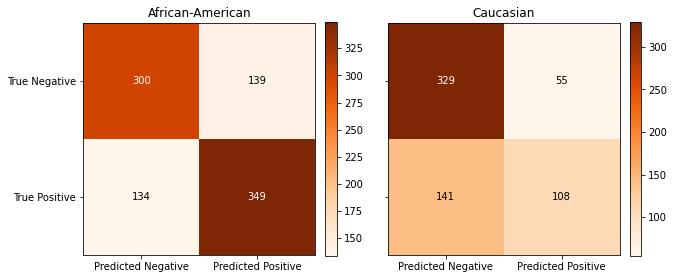

In [138]:
## if there is an error -- need to run random forest model code (commented out)
thresh = 200

# Calculate confusion matrices for each race
cm1 = confusion_matrix(df_blacks['y_test'], df_blacks['y_pred'])
cm2 = confusion_matrix(df_whites['y_test'], df_whites['y_pred'])

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot first confusion matrix
im1 = ax1.imshow(cm1, cmap=plt.cm.Oranges)
ax1.set_xticks(np.arange(2))
ax1.set_yticks(np.arange(2))
ax1.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
ax1.set_yticklabels(['True Negative', 'True Positive'])
plt.setp(ax1.get_xticklabels(), rotation=0, rotation_mode="anchor")
for i in range(2):
    for j in range(2):
        ax1.text(j, i, cm1[i, j], ha="center", va="center", color="white" if cm1[i, j] > thresh else "black")
ax1.set_title("African-American")

# Plot second confusion matrix
im2 = ax2.imshow(cm2, cmap=plt.cm.Oranges)
ax2.set_xticks(np.arange(2))
ax2.set_yticks(np.arange(2))
ax2.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
ax2.set_yticklabels(['', ''])
plt.setp(ax2.get_xticklabels(), rotation=0, rotation_mode="anchor")
for i in range(2):
    for j in range(2):
        ax2.text(j, i, cm2[i, j], ha="center", va="center", color="white" if cm2[i, j] > thresh else "black")
ax2.set_title("Caucasian")

# Add colorbar
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.show()

#### Variable Importance

Dalex uses drop-out loss to represent how much the overall accuracy of the model would decrease if a specific feature were removed. According to the chart, if the feature "priors_count" were removed, the model's information would decrease significantly. In constrast, it would have been better if the "race" feature was dropped because our models do not use the 'race' feature. 
Nevertheless, we need to examinate other metrics before making the conclusion

In [139]:
m_vi_list = [e.model_parts() for e in exp_list]

In [140]:
m_vi_list[0].plot(m_vi_list[1:])

**Partial Dependences**

After identifying the influential variables in all three models, the next step is to compare the relationship between these variables and the predicted response across the models. To do this, we use [Partial-dependence profiles (PDPs)](https://ema.drwhy.ai/partialDependenceProfiles.html), which are graphical representations of how a model's prediction changes as the value of a single input feature changes, while all other features remain constant. These profiles provide insight into the behavior of the models and help explain why they are making certain predictions.

The partial-dependence profiles for age and prior crimes show a general trend of increased predicted probability of recidivism with younger age and higher number of prior crimes. The relationship between the features and the target in logistic regression is modeled using a linear equation, resulting in a smooth partial-dependence profile curve. In contrast, decision trees and random forests use non-linear decision rules, leading to a more complex and non-linear relationship between the features and the target. As a result, the partial-dependence profiles for these models are not necessarily smooth and tend to be flatter. The difference also can be seen at the right edge of the age scale, which is likely due to random forest models' tendency to shrink predictions towards the average and poor extrapolation performance outside the range of values seen in the training data.

In [141]:
m_pdp_list = [e.model_profile(type = 'partial') for e in exp_list]

Calculating ceteris paribus: 100%|██████████| 7/7 [00:01<00:00,  5.38it/s]


In [142]:
m_pdp_list[0].plot(m_pdp_list[1:])

In the case of categorical variables, it is interesting to focus on race. The results show that being African-American increases the probability of recidivism for all three models, while the other races decrease it. This is related to the fact that, as a Washington Post article explains, if the recidivism rate for white and black defendants is the same within each risk category, and if black defendants have a higher overall recidivism rate, then a greater share of black defendants will be classified as high risk (will recidivate). As well, being female reduces the probability of recidivism, as does committing a misdemeanor crime.

When analyzing all categorical variables, the green bar for logistic regression is always bigger than the blue one for random forest. This is expected because, in general, random forest models shrink predictions towards the average.

In [143]:
m_pdp_cate_list = [e.model_profile(variable_type = 'categorical') for e in exp_list]
m_pdp_cate_list[0].plot(m_pdp_cate_list[1:])

Calculating ceteris paribus: 100%|██████████| 7/7 [00:01<00:00,  5.19it/s]


#### Instance-level Exploration

The previous global explorations give us a comprehensive perspective on our model by highlighting errors, determining the variables with the greatest overall impact, and exploring predictor-response relationships across all observations. Now we will look at the model's behavior at the instance-level to understand why a specific prediction was made for a particular instance. DALEX uses a technique called [Break Down]((https://ema.drwhy.ai/breakDown.html#BDMethod) to calculate localized variable importance scores. The basic idea is to calculate the contribution of variable in prediction of f(x) as changes in the expected model response given other variables. However, the values of Break-down plots may vary based on the order of the variables as it examines the contribution of each variable to the prediction while holding the previous variables constant. Thus, we also use [SHapley Additive exPlanations (SHAP)](https://ema.drwhy.ai/shapley.html#shapley) to which is based on the concept of Shapley values for local explaination.

**First Sample**

In [144]:
sample_1 = X_test.iloc[[3]]
sample_1.head()

,sex,age,race,priors_count,c_charge_degree,y_test,y_pred
6433,Female,25,African-American,5,F,1,1


When considering a 25-year-old African-American woman with 5 prior crimes charged with a felony, the global behavior of the variables applies to the local explanation of the prediction when fixing the values of the other variables: **her age, race, number of prior crimes, and charge increase the probability of recidivism, while her sex decreases it**.

In both models, random forest and logistic regression, the variable race = African-American increases the probability of recidivism, but in the random forest, it has a greater weight (0.029 compared to 0.018 in logistic regression). The same occurs with the other variables, where they have a greater absolute contribution in the random forest than in logistic regression. This is different from the analysis conducted in the global explanation, where it was mentioned that the effect of the variable race is greater for logistic regression compared to random forest. Overall, the prediction is higher than the mean.

In [145]:
sample_1_bd_list = [e.predict_parts(sample_1, type='break_down') for e in exp_list]
sample_1_bd_list[0].plot(sample_1_bd_list[1:])

*The row marked “intercept” represents the overall mean value of predictions for the entire dataset. Subsequent rows display changes in the mean prediction caused by fixing the value of a particular explanatory variable. Positive changes are shown with green bars, while negative differences are shown with red bars. The final row, marked “prediction,” is the sum of the overall mean value and the changes, i.e., the predicted value of recidivism probability for an individual, indicated by the blue bar.*

**The Shapley value** represents the average marginal contribution of a feature value across all possible combinations of the other features (i.e., all possible coalitions of features that are not being analyzed). For the sample_1 woman, in both logistic regression and random forest, all variables except gender increase the probability of recidivism, and the Shapley values have a similar behavior as seen in the Break-down plots.

In [146]:
sample_1_shap_list = [e.predict_parts(sample_1, type='shap') for e in exp_list]
sample_1_shap_list[0].plot(sample_1_shap_list[1:])

**Sample 2**

In [147]:
sample_2 = X_test.iloc[[20]]
sample_2

,sex,age,race,priors_count,c_charge_degree,y_test,y_pred
2465,Male,37,Caucasian,1,F,1,0


For a 37-years-old white man, with only 1 prior crime and charged with felony, the probability of recidivism is less than the mean. The variables that raise it are the c_charge_degree and sex. In the random forest, the race variable has the biggest decrease in the probability if we compare it to the same variable in the other two models. We connect this to the variable importance graphic presented before, where the feature "race" has some importance (0.001) in the random forest.

In this case, we can see that the contribution of each variable (except for the race) in the logistic regression is bigger in absolute terms than for the random forest, as we would expect since the random forest tends to shrink towards the mean.

In [148]:
sample_2_bd_list = [e.predict_parts(sample_2, type='break_down') for e in exp_list]
sample_2_bd_list[0].plot(sample_2_bd_list[1:])

When analyzing the Shapley values for the man in sample_2, the contribution of the variables in the logistic regression behaves similarly to what was shown in the break-down plot. However, in the random forest, when averaged across all possible combinations of other variables, the feature "race" increases the probability of recidivism, in contrast to the behavior shown in the break-down plot, where it reduces it.

Overall, for logistic regression and random forest, we can see that the most important variables for both local and global explanations are the number of prior crimes, age, and, to a lesser extent, gender. Regarding race, it seems to be important for the random forest, as its performance would decrease if it was removed. Additionally, when analyzing partial dependence, the effect is larger - in the global explanation - and it has a greater impact on the prediction when viewed in the context of local explanation, compared to the logistic regression.

In [149]:
sample_2_shap_list = [e.predict_parts(sample_2, type='shap') for e in exp_list]
sample_2_shap_list[0].plot(sample_2_shap_list[1:])

#### Model Fairness

The term "bias" is commonly used to describe disparities in algorithmic systems that are perceived as unjust or unethical from a societal standpoint. It's important to differentiate this meaning from the statistical definition of bias. In statistics and machine learning, the term bias has a well-established meaning that has been in use for a long time.

A statistical estimator is considered biased if its average or expected value diverges from the true value it aims to estimate. Statistical bias is a crucial concept in statistics, and there is a wide range of established techniques for analyzing and correcting it. Machine learning is based on historical data, which means it reproduces the patterns and relationships it finds in that data. If different groups have different base rates, the model will inevitably have different error rates. This requires providing the computer with a sufficient number of diverse examples to uncover subtle patterns and accurately generalize from historical cases to future ones. However, the fact that machine learning is evidence-based does not guarantee accurate, reliable, or fair decisions.

**"Fairness" Decision** <br>
That fairness decision is based on [epsilon](https://dalex.drwhy.ai/python/api/fairness/index.html), which is a parameter that defines acceptable fairness scores. The closer epsilon is to 1 the more strict the verdict is. If the ratio of certain unprivileged and privileged subgroup is within the (epsilon, 1/epsilon) range, then there is no discrimination in this metric and for these subgroups. As default, epsilon is set to 0.8 (it matches the four-fifths 80% rule).

We get the information about bias according to the metrics TPR (True Positive Rate), ACC (Accuracy), PPV (Positive Predictive Value), FPR (False Positive Rate), and STP(Statistical parity). The metrics are derived from a confusion matrix for each unprivileged subgroup and then divided by metric values based on the privileged subgroup. There are [3 types of possible conclusions](https://medium.com/responsibleml/how-to-easily-check-if-your-ml-model-is-fair-2c173419ae4c):

* `Not fair`: your model is not fair because 2 or more metric scores exceeded acceptable limits set by epsilon.

* `Neither fair or not`: your model cannot be called fair because 1 metric score exceeded acceptable limits set by epsilon.It does not mean that your model is unfair but it cannot be automatically approved based on these metrics.

* `Fair`: your model is fair in terms of checked fairness metrics.

To determine if the model has any bias, we will use the `fairness` module from Dalex.<br>
* `protected`: An array-like object that contains subgroup values that represent a sensitive attribute, such as sex or nationality. The fairness metrics will be calculated for each of these subgroups and compared.

* `privileged`: A string that specifies one of the subgroups, which is suspected of having the most privilege. This string will be used as a reference point for comparison with the other subgroups.

According to ProPublica, Caucasian individuals was determined to be underpredicted. Hence, this group was selected as the privileged group to see if our model is also privileged them.

In [150]:
mf_list = [e.model_fairness(protected = race_test, privileged = "Caucasian") for e in exp_list]

In [151]:
mf_list[0].plot(mf_list[1:])

* Equal opportunity ratio = A classifier satisfies this definition if the subjects in the protected and unprotected groups have equal FNR (or equal TPR, since TPR= 1-FNR).

* Predictive parity ratio = A classifier satisfies this definition if the subjects in the protected and unprotected groups have equal Positive Predictive Value (PPV)

* Predictive equality ratio = A classifier satisfies this definition if the subjects in the protected and unprotected groups have aqual FPR.

* Accuracy equality ratio = A classifier satisfies this definition if the subject in the protected and unprotected groups have equal prediction accuracy, that is, the probability of a subject from one class to be assigned to it.

* Statistical parity ratio= A classifier satisfies this definition if the subjects in the protected and unprotected groups have equal probability of being assigned to the positive predicted class.

According to the fairness check, the logistic regression model, decision three and random forest are not fair. This is because the ratios for TPR, FPR and STP exceed the threshold (should be between 0.8 and 1.25). We can also observe the same graphically in the previous chart Fairnes Check, there the ratios for the mentioned matrix are in the red zone (over the threshold).

We analyse these metrics for African-Americans:

* TPR: all models have a higher sensitivity or recall for black people, which means that the model succeeds well in finding all the positive cases in the data, even though they may also wrongly identify some negative cases as positive cases. Again, this was one of the complaints from ProPoblica.

* FPR: this metric is also higher for black defendants, since it's related to the previous explanation: the model finds more positive cases, with the downsize that it also labels someone who didn't reoffend as "will recidivate".

* STP: this ratio shows that black defendants are assigned a positive outcome (will reoffend) more often than white defendants. This is also related to the results in TPR and FPR.

In [152]:
for mf in mf_list:
    print(mf.label)
    mf.fairness_check()
    print("\n")

Logistic Regression
Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  2.053824  1.048817  1.082459  2.678261  2.516746
Hispanic          0.677054  0.954142  0.959520  0.765217  0.708134
Other             0.504249  1.017751  1.089955  0.313043  0.411483


Decision Tree
Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.642857  1.022659  1.160331  1.813953  1.886364
Hispanic  

In [153]:
mf_list[0].plot(mf_list[1:],type = 'stacked')

In [154]:
mf_list[0].plot(mf_list[1:],type = 'radar')

In [155]:
mf_list[0].plot(mf_list[1:],type = 'heatmap')

#### Conclusion
Overall, "priors_count" and "age" are important predictors for the target variable in all three models. Our analysis shows that the performance of our random forest model is only slightly better than the simple logistic model. While there are tools available to help us understand the "black box" nature of the random forest model, the logistic model is still easier to interpret and understand due to its straightforward linear equation. However, it is important to note that all three models are unfair, and this limitation highlights the need for continued work to address biases in algorithmic systems. As machine learning methods play an increasingly important role in our society, it is crucial that we remain aware of their limitations and work to improve their fairness and accuracy.

## Further Discussion

### Question 2.

#### 2.1 Are interpretable models just as accurate as black box machine learning models for predicting recidivism?

Interpretable models are machine learning models that help provide understandable explanations of their predictions and decision-making processes. The term “Black box machine learning models” refers to models that are not interpretable by humans because they lack transparency. Examples for black box machine learning models include neural networks. The opposite of black box machine learning models are interpretable models, sometimes also referred to as “White box models” or “Glass box models”. They are understandable and verifiable by humans, thus they are transparent. An example for an interpretable model is a logistic regression (compare Molnar 2022). 

This opacity terminology not only describes missing transparency in the algorithms themselves, but voluntary missing transparency, which is caused by the companies who develop them. Even interpretable models can be black box models, when how they work isn’t revealed by the companies - as is the case with the COMPAS algorithm that will be discussed in the next paragraph.  These algorithms are proprietary. The company’s financial benefits from selling the model would be lost, if how they work would be public as Cynthia Rudin, a scientist who advocates for interpretable models in high stake decisions, points out (2019, p.9).


Rudin argues that interpretable models can be just as accurate as black box machine learning models for predicting recidivism. In the case of the COMPAS algorithm, the interpretable alternative is COREL. COREL is a model that only uses age, priors and optionally gender. Both COMPAS and COREL “have similar true and false positive and true and false negative rates on data from Broward County, Florida” (Rudin 2019, p. 6). 

For machine learning models in general Rudin even goes as far as to state that interpretable models could even have in-practice a higher accuracy, because typographical errors can occur in the datasets and can then have an impact on the predicted outcome (2019, p.5).  Nevertheless there is a point in the fact that interpretable models are just as accurate as “the machine learning researcher’s ability to create accurate-yet-interpretable models” (2019, p. 8) allows the model to be. So definitely interpretable models aren’t automatically as accurate as black box machine learning models.

Before moving on to the discussion of transparency, it should be briefly mentioned that even if there is not necessarily a tradeoff between accuracy and interpretability, there is one for interpretability and flexibility. As Gareth et al. put it “In general, as the flexibility of a method increases, its interpretability decreases.” (2013, p. 25)

#### 2.2 Can complex models be as transparent as simple ones?
That being said, be cautious that “interpretable machine learning” and “explainable machine learning” are often used interchangeably, but as Rudin argues, should be differentiated and used consciously on a common ground (2019, p.14). She defines interpretable models as models that are inherently interpretable. Whereas explainable models, in her perception, are black box models that are explained using a second (posthoc) model. Which then in turn is also the reason why troubleshooting the model is also very difficult and time-consuming. 

One of her main arguments for interpretable models, in comparison with explainable models, is “explanations are often not reliable, and can be misleading [...]. If we instead use models that are inherently interpretable, they provide their own explanations, which are faithful to what the model actually computes.” (2019, p.1) This means, the explanation model is always just an approximation of how the black box model functions. 

Zachary Lipton doesn’t make this differentiation, between interpretability and explainability, but agrees that “the task of interpretation appears underspecified” and also that “transparency to humans and post-hoc explanations [are] competing notions” (2017, p.1).
In trying to specify interpretability he considers different levels of transparency, this being the opposite of opacity:
“transparency at the level of the entire model (simulatability), 
at the level of individual components (e.g. parameters) (decomposability), 
and at the level of the training algorithm (algorithmic transparency).” (2017, p.4)
The derived levels of interpretability are therefore: 
Algorithm Transparency: “How does the algorithm create the model?” (Molnar 2022),
Global, Holistic Model Interpretability: “How does the trained model make predictions?” (Molnar 2022),
Global Model Interpretability on a Modular Level: “How do parts of the model affect predictions?” (Molnar 2022),
Local Interpretability for a Single Prediction: “Why did the model make a certain prediction for an instance?” (Molnar 2022),
Local Interpretability for a Group of Predictions: “Why did the model make specific predictions for a group of instances?” (Molnar 2022).

Lipton concludes that “. Linear models are not strictly more interpretable than deep neural networks”, but equal, less or more interpretable depending on the level of interpretability that one is concerned about (2017, p. 7).

Rudin agrees indirectly when stating that even with her differentiation or explainable and interpretable models “there is a spectrum between fully transparent models (where we understand how all the variables are jointly related to each other) and models that are lightly constrained in model form (such as models that are forced to increase as one of the variables increases, or models that, all else being equal, prefer variables that domain experts have identified as important)” (2019, p. 1). 

#### 2.3 How do I communicate nonlinear dependencies?

Non-linear dependencies, also referred to as non-linear relationships, play an important role in the interpretability of models. Non-linear dependencies describe relationships between the predicting features and the predicted response of the model and are inherent to the features and predicted response, so they do occur for both black box models as well as interpretable models (Gareth et al. 2013, p.90ff). 
The ability of a model to adjust to these non-linear dependencies depends on the model's flexibility. It was already briefly mentioned that there is a tradeoff between flexibility and interpretability. Meaning that complex models, including black box machine learning models which are not interpretable by humans, can adapt better to these dependencies.

Consequently it is important to choose the right model. The model in turn can help communicate the non-linear dependencies:
For example, a decision tree can show the specific conditions that lead to a certain prediction, and how those conditions are interconnected. A linear regression model with non-linear dependencies could be better expressed by a polynomial regression function as follows: 
yi = β0 + β1xi1 + β2xi2 + ··· + βpxip + i
Another way to communicate non-linear dependencies in linear regression - but also for classification problems - are generalized additive models (GAM). Generalized additive models model each feature with a non-linear function. Then these functions are weighed and summed. Apart from these three there are even more models, including step functions and regression splines, etc. (compare Gareth et al. 2013, p.265ff; Molnar 2022).

Apart from choosing the right model the non-linear dependencies can also be analyzed directly by performing a feature importance analysis. It can show the contribution of the features involved. This in turn can help for feature tuning and minimizing the number of features for interpretable models. A feature importance analysis can be performed using permutation. Molnar explains “A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction.” (2022)


### Question 5. How can I find relevant interactions?

There are several ways to statistically find relevant interactions between features in an interpretable machine learning model. Some common methods include:

**Using interaction terms**: One way to find interactions between features is by creating interaction terms. Because the “magnitude of the interaction effect in nonlinear models does not equal the marginal effect of the interaction term, the magnitude of the interaction of the variable effect then depends on all the covariates in the model” (Ai and Norton, p. 154)., which are the product of two or more predictor variables. These interaction terms can be added to the model as new predictors, and their coefficients can be used to evaluate the strength and significance of the interactions.

**Using partial dependence plots**: Another way to find interactions between features is by using partial dependence plots. Jerome H. Friedman (p. 1219) explained that “Functions of a categorical variable and another variable (real or categorical) are best summarized by a sequence of(''trellis”) plots, each one showing the dependence of first input on the second variable, conditioned on the respective values of the first variable”. Essentially, the plots show the relationship between a predictor and the outcome variable, holding all other predictors constant.

**Using Permutation Importance**: Feature importance provides a highly compressed, global insight into the model’s behavior (Christoph Molnar). By using Permutation Importance as a way to understand the feature importance, shuffling the values of a feature and observing the change in the performance of the model. The features that have a larger effect on the model performance when shuffled are considered more important. 

**Using SHapley Additive exPlanations (SHAP) values**: Based on the Shapley documentation, SHAP values are a unified measure of feature importance that assigns each feature an importance value for a particular prediction. Originally a game theoretic approach to explain the output of any machine learning model, It connects optimal credit allocation with local explanations using classic Shapley values. By comparing the SHAP values for different features, you can identify interactions between features.

It's important to note that none of these methods are foolproof in finding interactions. The best way to find interactions is through experimentation and testing different combinations of features and also visualizing the data, will give a better understanding of the relationship between features. 
We know from several sources that in the data from Broward County, Florida, age and priors interact with race. But in order to know to which extent they interact, we would have to conduct one or several of the above mentioned methods.



## Final Conclusion

As previously mentioned, the performance of a machine learning model is largely dependent on the quality of the data used to train it. In the case of recidivism prediction, the higher base rate of African-Americans (52%) compared to other races (39%) results in different error rates between the two groups. If the recidivism rate is the same within each risk category, regardless of race, then a higher proportion of black defendants will be classified as high risk, even if they do not reoffend. This leads to a higher False Positive Rate (FPR) for black defendants. 

The COMPAS algorithm is therefore biased, but not because of bad intentions of those creating it. We believe that they aimed for fairness as they had similar predictive values. Nonetheless, the bias is a result of the systemic racism and social conditions that impact the data used to train the models.

It is crucial to be mindful of the limitations of machine learning methods when making decisions that could greatly impact a person's future. Algorithms can provide valuable insights, but they are simply a reflection of the current system. As humans, it is our responsibility to work towards creating a better and more equitable reality.

## References

Markus Waser, “Nonlinear Dependencies in and between Time Series” retrieved from: https://publik.tuwien.ac.at/files/PubDat_189752.pdf<br>

Patrick Hall, “Predictive modeling: Striking a balance between accuracy and interpretability”. Retrieved from: https://www.oreilly.com/content/predictive-modeling-striking-a-balance-between-accuracy-and-interpretability/<br>

Chunrong Ai and Edward C. Norton, “Computing interaction effects and standard errors in logit and Probit models” retrieved from: https://hhstokes.people.uic.edu/ftp/e535/probit/NortonWangAi.pdf<br>

Jerome H. Friedman, "Greedy function approximation: A gradient boosting machine.." Ann. Statist. 29 (5) 1189 - 1232, October 2001. Retrieved from: https://doi.org/10.1214/aos/1013203451<br>

Molnar, Christoph. “Interpretable Machine Learning: A Guide for Making Black Box Models Explainable” (2022): Chapter: Permutation Feature Importance
Slundberg/shap · GitHub<br>

Rudin, Cynthia. “Stop Explaining Black Box Machine Learning Models for High Stakes Decisions and use Interpretable Models Instead” (2019): Nature Machine Intelligence. Retrieved from: https://arxiv.org/abs/1811.10154 <br>

Ai, C., & Norton, E. C. (2004). Computing interaction effects and standard errors in logit and Probit models. Retrieved January 15, 2023, from https://hhstokes.people.uic.edu/ftp/e535/probit/NortonWangAi.pdf.

Oh, S. (2019). Feature Interaction in Terms of Prediction Performance. Applied Sciences, 9(23), 5191. https://doi.org/10.3390/app9235191

Friedman, Jerome H. (2001): Greedy function approximation: A gradient boosting machine… Ann. Statist. 29 (5) 1189 - 1232. Retrieved January 15, 2023, from https://doi.org/10.1214/aos/1013203451/

Molnar, Christoph (2022): Interpretable Machine Learning: A Guide for Making Black Box Models Explainable. Retrieved January 12, 2023, from  https://christophm.github.io/interpretable-ml-book/feature-importance.html

Lundberg, S. (2020, December 18). Welcome to the SHAP documentation Retrieved from https://github.com/slundberg/shap/blob/master/docs/index.rst